In [1]:
import math
import torch
import numpy as np
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from imputation_model import *
from train import *
from utils import *
from losses import *

In [3]:
import scanpy as sc
from scipy import sparse

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
def e2eImpute(adata,
              project='AE',
              imputation='GAE',
              k=3,
              distance='hyperbolic',
              z_dim=64,
              y_dim=128,
              pro_dim1=128,
              pro_dim2=1024,
              use_raw=True,
              no_cuda=False,
              epochs=1000,
              lr=0.001,
              weight_decay=0.0005,
              patience=200,
              alpha=0.1,
              beta=0.9,
              gamma=0.5,
              fastmode=False,
              verbose=True):
    
    adata = adata.copy()
    adata = normalize(adata, filter_min_counts=False)
    
    true_values=torch.tensor(adata.raw.X.A, dtype=torch.float).to(device)
    size_factors = torch.tensor(adata.obs.size_factors, dtype=torch.float).reshape(-1, 1).to(device)
    
    data=torch.tensor(adata.X, dtype=torch.float).to(device)
    model=IntegratedModel(data,size_factors=size_factors, project=project, imputation=imputation, k=k, distance=distance,
                         z_dim=z_dim, y_dim=y_dim, pro_dim1=pro_dim1, pro_dim2=pro_dim2, use_raw=use_raw).to(device)
    print(model)

    train(data=data, true_values=true_values, model=model,
          project=project, imputation=imputation, no_cuda=no_cuda, epochs=epochs, lr=lr, weight_decay=weight_decay,
          patience=patience, alpha=alpha, beta=beta,gamma=gamma, fastmode=fastmode, verbose=verbose)

    
    if project == 'AE' and imputation == 'GAE':
        output_mlp, pred = model(data)
        result = pred.detach().cpu()
    if project == 'AE' and imputation == 'VGAE':
        output_mlp, pred, z_mean, z_dropout, z_dispersion = model(data)
        result = pred.detach().cpu()
    if project == 'VAE' and imputation == 'GAE':
        output_mlp, _, _, _, pred = model(data)
        result = pred.detach().cpu()
    if project == 'VAE' and imputation == 'VGAE':
        output_mlp, _, _, _, pred, _, _, _ = model(data)
        result = pred.detach().cpu()

    return result

In [5]:
def pearsonr_error(y, h):
    res = []
    if len(y.shape) < 2:
        y = y.reshape((1, -1))
        h = h.reshape((1, -1))

    for i in range(y.shape[0]):
        res.append(pearsonr(y[i], h[i])[0])
    return np.mean(res)


def cosine_similarity_score(y, h):
    if len(y.shape) < 2:
        y = y.reshape((1, -1))
        h = h.reshape((1, -1))
    cos = cosine_similarity(y, h)
    res = []
    for i in range(len(cos)):
        res.append(cos[i][i])
    return np.mean(res)

In [6]:
adata = sc.read_h5ad('./data/Klein_top2000/masked/Klein_top2000_00.h5ad')

In [10]:
%%time
result = e2eImpute(adata=adata,
                    project='AE',
                    imputation='VGAE',
                    k=450,
                    distance='hyperbolic', #euclidean, manhattan, hyperbolic, cosine
                    z_dim=256,
                    y_dim=1024,
                    pro_dim1=128,
                    pro_dim2=1024,
                    use_raw=False,
                    no_cuda=False,
                    epochs=80,
                    lr=0.001, # 0.001 for GAE, 0.0001 for VGAE
                    weight_decay=0.0005,
                    patience=200,
                    alpha=0.3,
                    beta=0.3,
                    gamma=0.1,
                    fastmode=False,
                    verbose=True)

IntegratedModel(
  (mlp): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=2000, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=256, out_features=2000, bias=True)
    )
  )
  (vae): VAE(
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.4, inplace=False)
    (dense1): Linear(in_features=2000, out_features=256, bias=True)
    (batchn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense2_mean): Linear(in_features=256, out_features=2000, bias=True)
    (dense2_dropout): Linear(in_features=256, out_features=2000, bias=True)
    (dense2_dispersion): Linear(in_features=256, out_features=2000, bias=True)
    (fc1): Linear(in_features=2000, out_features=1024, bias=True)
    (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=1024, out_features=2000, bias=True)
    (batch_norm1): BatchNorm1d(2000, eps=1

SparseTensor(row=tensor([   0,    0,    0,  ..., 2712, 2712, 2712], device='cuda:0'),
             col=tensor([   0,    3,    4,  ..., 2709, 2711, 2712], device='cuda:0'),
             size=(2713, 2713), nnz=1220850, density=16.59%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 2712, 2712, 2712], device='cuda:0'),
             col=tensor([   0,    3,    4,  ..., 2709, 2711, 2712], device='cuda:0'),
             size=(2713, 2713), nnz=1220850, density=16.59%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 2712, 2712, 2712], device='cuda:0'),
             col=tensor([   0,    3,    4,  ..., 2709, 2711, 2712], device='cuda:0'),
             size=(2713, 2713), nnz=1220850, density=16.59%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 2712, 2712, 2712], device='cuda:0'),
             col=tensor([   0,    3,    4,  ..., 2709, 2711, 2712], device='cuda:0'),
             size=(2713, 2713), nnz=1220850, density=16.59%)
Epoch: 0030 loss_train: 16.9680
SparseTensor(row=tensor([   0,    0,

SparseTensor(row=tensor([   0,    0,    0,  ..., 2712, 2712, 2712], device='cuda:0'),
             col=tensor([   0,    3,    4,  ..., 2709, 2711, 2712], device='cuda:0'),
             size=(2713, 2713), nnz=1220850, density=16.59%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 2712, 2712, 2712], device='cuda:0'),
             col=tensor([   0,    3,    4,  ..., 2709, 2711, 2712], device='cuda:0'),
             size=(2713, 2713), nnz=1220850, density=16.59%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 2712, 2712, 2712], device='cuda:0'),
             col=tensor([   0,    3,    4,  ..., 2709, 2711, 2712], device='cuda:0'),
             size=(2713, 2713), nnz=1220850, density=16.59%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 2712, 2712, 2712], device='cuda:0'),
             col=tensor([   0,    3,    4,  ..., 2709, 2711, 2712], device='cuda:0'),
             size=(2713, 2713), nnz=1220850, density=16.59%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 2712, 2712, 2712], 

##### Metrics calculation

In [11]:
mse = float('%.4f' % mean_squared_error(adata.raw.X.A, np.asarray(sparse.csc_matrix.todense(adata.X))))
mae = float('%.4f' % mean_absolute_error(adata.raw.X.A, np.asarray(sparse.csc_matrix.todense(adata.X))))
pcc = float('%.4f' % pearsonr_error(adata.raw.X.A, np.asarray(sparse.csc_matrix.todense(adata.X))))
cs = float('%.4f' % cosine_similarity_score(adata.raw.X.A, np.asarray(sparse.csc_matrix.todense(adata.X))))

In [12]:
print(mse,mae,pcc,cs)

0.0 0.0 1.0 1.0


In [13]:
mse = float('%.4f' % mean_squared_error(adata.raw.X.A, result))
mae = float('%.4f' % mean_absolute_error(adata.raw.X.A, result))
pcc = float('%.4f' % pearsonr_error(adata.raw.X.A, result))
cs = float('%.4f' % cosine_similarity_score(adata.raw.X.A, result))

In [14]:
print(mse,mae,pcc,cs)

13.3065 0.986 0.807 0.825


In [15]:
adata.obs

,cluster,n_genes_by_counts,total_counts,n_genes,total_counts_mt,pct_counts_mt
0-d0,d0,14195,39366.0,14195,0.0,0.0
1-d0,d0,15330,44271.0,15330,0.0,0.0
2-d0,d0,15055,46656.0,15055,0.0,0.0
3-d0,d0,12729,30461.0,12729,0.0,0.0
4-d0,d0,7455,13396.0,7455,0.0,0.0
...,...,...,...,...,...,...
793-d7,d7,12538,31558.0,12538,0.0,0.0
794-d7,d7,16431,53669.0,16431,0.0,0.0
795-d7,d7,12634,30256.0,12634,0.0,0.0
796-d7,d7,16333,48644.0,16333,0.0,0.0


In [16]:
clusters = adata.obs.cluster.values #klein
#clusters = adata.obs.level1class.values #zeisel

In [17]:
import copy
adata_pred = sc.AnnData(copy.deepcopy(result.cpu().numpy()))

In [18]:
sc.pp.normalize_total(adata_pred)
sc.pp.log1p(adata_pred)
sc.pp.highly_variable_genes(adata_pred, n_top_genes=2000)
adata_pred = adata_pred[:, adata_pred.var.highly_variable]
print(adata_pred.X.shape)
sc.pp.scale(adata_pred, max_value=10)

(2713, 2000)


D:\Anaconda3\envs\PyTorch\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:269: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(
D:\Anaconda3\envs\PyTorch\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [19]:
%%time
random_seed = np.random.randint(0, 10000)  
print("The seed is:", random_seed)

kmeans = KMeans(n_clusters=len(set(clusters)), n_init=100, random_state=random_seed).fit(adata_pred.X)
ari = float('%.4f' % adjusted_rand_score(clusters, kmeans.labels_))
nmi = float('%.4f' % normalized_mutual_info_score(clusters, kmeans.labels_))
print(ari,nmi)

The seed is: 7187
0.7935 0.7899
CPU times: total: 1min 9s
Wall time: 7.32 s


In [37]:
adata_pred.obs['cluster']=adata.obs['cluster'].values #klein

In [38]:
adata_pred.obs

,cluster
0,d0
1,d0
2,d0
3,d0
4,d0
...,...
2708,d7
2709,d7
2710,d7
2711,d7


In [39]:
sc.tl.pca(adata_pred, svd_solver='arpack')
sc.pp.neighbors(adata_pred, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_pred)

D:\Anaconda3\envs\PyTorch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


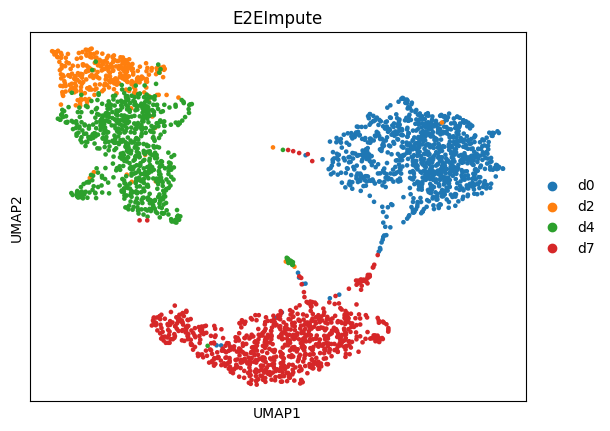

In [40]:
sc.pl.umap(adata_pred, color=['cluster'], title='E2EImpute', frameon=True)

In [41]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(adata_pred.obsm['X_umap'],kmeans.labels_)

In [42]:
print("mse: ", mse)
print("mae: ", mae)
print("pcc: ", pcc)
print("cs: ", cs)
print("ari: ", ari)
print("nmi: ", nmi)
print("silhouette score: ", sil_score)

mse:  3.3309
mae:  0.8302
pcc:  0.9322
cs:  0.9403
ari:  0.8074
nmi:  0.802
silhouette score:  0.6116394


### Save imputed data to disk

In [39]:
result.cpu().numpy().shape, result.cpu().numpy().dtype

((2713, 2000), dtype('float32'))

In [40]:
import scipy.io as sio
from scipy.sparse import csr_matrix 

In [41]:
sio.mmwrite('./predicted_data/my_model/klein/klein00_top2000_e2eimpute.mtx',csr_matrix(result.cpu().numpy().T))